In [46]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Union
from matplotlib.axes import Axes
from sklearn.metrics import roc_curve, auc

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [5]:
def evaluate_deepphos(
    true_filename: str,
    result_filename_deepphos: str,
    threshold_score:float = 0.5
)-> List:

    data_true = pd.read_csv(true_filename, header=None)
    data_true.columns = ["label", "name", "position", "sseq"]
    threshold_score = 0.5

    f = open(result_filename_deepphos)
    lines = f.readlines()
    TP=0
    TN=0
    FP=0
    FN=0
    y_true=[]
    y_score=[]

    for line in lines:
        line=line.replace('"', '').split()
        name = line[0]
        position_p = int(line[1])
        score = float(line[2])
        rows = data_true[data_true['name'] == name]
        row = rows[rows['position']==position_p]
        if not row.empty:
            label_true = row['label'].iloc[0]
            if score>=threshold_score:
                label_p=1
            else:
                label_p=0
            if label_p==1 and label_true==1:
                TP=TP+1
            elif label_p==0 and label_true==0:
                TN=TN+1
            elif label_p==1 and label_true==0:
                FP=FP+1
            elif label_p==0 and label_true==1:
                FN=FN+1
            y_true.append(label_true)
            y_score.append(score)

        else:
            print(line)
            print('no data')

    f.close()

    Sn=TP/float(TP+FN)
    Sp=TN/float(TN+FP)
    Pre=TP/float(TP+FP)
    Acc=(TP+TN)/float(TP+TN+FP+FN)
    MCC=float(TP*TN-FP*FN)/math.sqrt((TP+FN)*(TP+FP)*(TN+FN)*(TN+FP))
    F1 = (2*Pre*Sn)/float(Pre+Sn)

    return [Sn, Sp, Pre, Acc, MCC, F1, y_true, y_score]

In [6]:
def evaluate_musitedeep(
    true_filename: str,
    result_filename_muistedeep: str,
    dividing_score: float = 0.5
)-> List:
    
    # 读取MusiteDeep文件

    # 真值文件
    true_df = pd.read_csv(true_filename, header=None)
    true_df.columns = ['label', 'prot', 'pos', 'rawseq']
    # 测试文件
    result_df = pd.read_csv(result_filename_muistedeep)


    # 读取MusiteDeep测试结果

    divisor_score = 0.5 # 划分正负样本的分界值，区间[0, 1]划分后统一左闭右开

    predict_positive = dict()
    predict_negative = dict()

    for i in range(len(result_df)):
        prot = result_df.iloc[i]['prot']
        pos = result_df.iloc[i]['pos']
        predict_score = result_df.iloc[i]['label']

        if predict_score >= divisor_score:
            ls_pos = predict_positive.setdefault(prot, list())
            ls_pos.append(pos)
        else:
            ls_pos = predict_negative.setdefault(prot, list())
            ls_pos.append(pos)

    
    # 读取MusiteDeep真值，并计算TP、FP、TN、FN

    TP, FP, TN, FN = 0, 0, 0, 0
    ls_label = list()
    ls_predict_score = list()

    for i in range(len(true_df)):
        label = true_df.iloc[i]['label']
        prot = true_df.iloc[i]['prot']
        pos = true_df.iloc[i]['pos']

        if label == 1:
            if pos in predict_positive.get(prot, list()):
                TP += 1
                ls_label.append(label)
                ls_predict_score.append(result_df.loc[(result_df['prot'] == prot) & (result_df['pos'] == pos), ['label']]['label'])
            
            elif pos in predict_negative.get(prot, list()):
                FN += 1
                ls_label.append(label)
                ls_predict_score.append(result_df.loc[(result_df['prot'] == prot) & (result_df['pos'] == pos), ['label']]['label'])
        
        else:
            if pos in predict_negative.get(prot, list()):
                TN += 1
                ls_label.append(label)
                ls_predict_score.append(result_df.loc[(result_df['prot'] == prot) & (result_df['pos'] == pos), ['label']]['label'])
            
            elif pos in predict_positive.get(prot, list()):
                FP += 1
                ls_label.append(label)
                ls_predict_score.append(result_df.loc[(result_df['prot'] == prot) & (result_df['pos'] == pos), ['label']]['label'])


    # 计算MusiteDeep各个指标值
    Sn  =   TP / float(TP + FN)
    Sp  =   TN / float(TN + FP)
    Pre =   TP / float(TP + FP)
    Acc =   (TP + TN) / float(TP + TN + FP + FN)
    MCC =   float(TP * TN - FP * FN) / math.sqrt((TP+FN) * (TP+FP) * (TN+FN) * (TN+FP))
    F1  =   (2 * Pre * Sn) / float(Pre + Sn)

    return [Sn, Sp, Pre, Acc, MCC, F1, ls_label, ls_predict_score]

In [7]:
def evaluate(
    true_filename: str,
    result_filename_deepphos: str,
    result_filename_muistedeep: str,
    dividing_score: float = 0.5
)-> Tuple[List, List]:
    '''
    评估DeepPhos和MusiteDeep模型
    
    :param true_filename: 结合位点标注的csv文件地址
    :param result_filename_deepphos: DeepPhos预测结果的txt文件地址
    :param result_filename_muistedeep: MusiteDeep预测结果的csv文件地址
    :param dividing_score: 分割正负样本的判别值，默认为0.5
    :returns: [Sn_deep, Sp_deep, Pre_deep, Acc_deep, MCC_deep, F1_deep, ls_label_deep, ls_predict_score_deep], 
        [Sn_musite, Sp_musite, Pre_musite, Acc_musite, MCC_musite, F1_musite, ls_label_musite, ls_predict_score_muiste]
    '''

    return (evaluate_deepphos(true_filename, result_filename_deepphos, dividing_score), 
        evaluate_musitedeep(true_filename, result_filename_muistedeep, dividing_score))

In [8]:
def print_metrics(metrics_deepphos: List, metrics_musitedeep: List)-> None:

    [Sn_deep, Sp_deep, Pre_deep, Acc_deep, MCC_deep, F1_deep, _, _] = metrics_deepphos
    [Sn_musite, Sp_musite, Pre_musite, Acc_musite, MCC_musite, F1_musite, _, _] = metrics_musitedeep

    # 输出DeepPhos参量
    print('DeepPhos:')
    print(
        "Sn:"+str(Sn_deep)+";",
        "Sp:"+str(Sp_deep)+";",
        "Pre:"+str(Pre_deep)+";",
        "Acc:"+str(Acc_deep)+";",
        "MCC:"+str(MCC_deep)+";",
        "F1:"+str(F1_deep),
        sep='\n',
        end='\n\n'
        )

    # 输出MuisteDeep参量
    print('MusiteDeep:')
    print(
        "Sn:"+str(Sn_musite)+";",
        "Sp:"+str(Sp_musite)+";",
        "Pre:"+str(Pre_musite)+";",
        "Acc:"+str(Acc_musite)+";",
        "MCC:"+str(MCC_musite)+";",
        "F1:"+str(F1_musite),
        sep='\n'
        )

In [38]:
def plot_metrics_bar(
    ax: Axes,
    title: str,
    metrics_deepphos: List,
    metrics_musitedeep: List,
    bar_width: float = 0.25
)-> None:

    [Sn_deep, Sp_deep, Pre_deep, Acc_deep, MCC_deep, F1_deep, _, _] = metrics_deepphos
    [Sn_musite, Sp_musite, Pre_musite, Acc_musite, MCC_musite, F1_musite, _, _] = metrics_musitedeep

    y_deepphos = [Sn_deep, Acc_deep, MCC_deep, Pre_deep, F1_deep]
    y_musitedeep = [Sn_musite, Acc_musite, MCC_musite, Pre_musite, F1_musite]

    colors = ['#FF4B63', '#FFD500']

    x = [0, 1, 2, 3, 4]
    ax.bar(x, y_deepphos, color=colors[0], width=bar_width, label='DeepPhos')
    x = [i + bar_width for i in x]
    ax.bar(x, y_musitedeep, color=colors[1], width=bar_width, label='MusiteDeep')

    ax.legend(loc='best')

    # x轴标签
    tick_label = ['Sn', 'Acc', 'MCC', 'Pre', 'F1']
    ax.set_xticks([i - bar_width/2 for i in x])
    ax.set_xticklabels(tick_label)

    # x、y轴范围
    ax.set_ylim(0, 1.05)

    # 标题
    ax.set_title(title)

In [28]:
def plot_roc_curve(
    ax: Axes,
    title: str,
    metrics_deepphos: List,
    metrics_musitedeep: List,
    lw: Union[int, float] = 2,
)-> None:
    
    [_, _, _, _, _, _, ls_label, ls_predict_score] = metrics_deepphos
    [_, _, _, _, _, _, y_true, y_score] = metrics_musitedeep

    fpr, tpr, thread = roc_curve(ls_label, ls_predict_score)
    roc_auc= auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=lw, label='MusiteDeep=%f' % roc_auc)

    fpr, tpr, thread = roc_curve(y_true, y_score)
    roc_auc= auc(fpr, tpr)
    ax.plot(fpr, tpr, color='navy',lw=lw, label='DeepPhos=%f' % roc_auc)

    ax.legend(loc='best')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('1-Sp')
    ax.set_ylabel('Sn')
    ax.set_title(title)

In [9]:
# 读取数据并完成评估

true_filename = 'true_result\test_output.csv'
result_filename_deepphos = 'deepphos_result\general_(\'S\', \'T\')prediction_phosphorylation.txt'
result_filename_muistedeep = 'musitedeep_result2csv\data_musitedeep.csv'

metrics_deepphos, metrics_musitedeep = evaluate(true_filename, result_filename_deepphos, result_filename_muistedeep)

In [10]:
# 输出指标

print_metrics(metrics_deepphos, metrics_musitedeep)

DeepPhos:
Sn:0.9353905496624879;
Sp:0.5144648023143684;
Pre:0.6582965727858839;
Acc:0.7249276759884281;
MCC:0.4959296477349022;
F1:0.7727544313881697

MusiteDeep:
Sn:0.9469623915139826;
Sp:0.7420443587270974;
Pre:0.7859143657462985;
Acc:0.84450337512054;
MCC:0.7039450718788444;
F1:0.8589547343100808


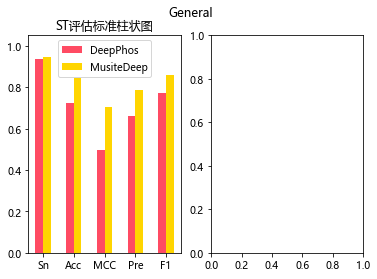

In [47]:
# 绘制指标柱状图

fig, axs = plt.subplots(1, 2)
plot_metrics_bar(axs[0], 'ST评估标准柱状图', metrics_deepphos, metrics_musitedeep)
plt.suptitle('General')
plt.show()

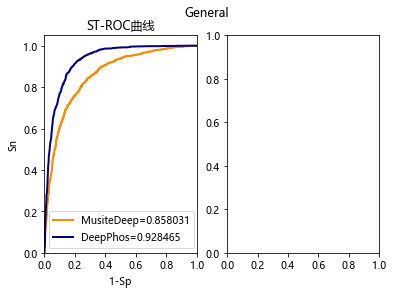

In [48]:
# 绘制ROC曲线

fig, axs = plt.subplots(1, 2)
plot_roc_curve(axs[0], 'ST-ROC曲线', metrics_deepphos, metrics_musitedeep)
plt.suptitle('General')
plt.show()